# Task 3.2

**Classification/Regression**
- *Write a Python program to build and test a model for each dataset
mentioned above. For this task, you should use the dataset obtained
after completing Task 3.1.*
- *Markdown Question: Is Linear Regression a good model to use for
the star dataset? Justify your answer.*

## Table of Contents
- [Imports](#Imports)
- [Star Dataset](#Star-Dataset)
    - [Train and evaluate an SVM classifier using the holdout method](#Train-and-evaluate-an-SVM-classifier-using-the-holdout-method)
    - [Train and evaluate an SVM classifier using cross-validation](#Train-and-evaluate-an-SVM-classifier-using-cross-validation)
    - [Perform SVM classifier hyperparameter tuning](#Perform-SVM-classifier-hyperparameter-tuning)
    - [Evaluate the tuned SVM classifier](#Evaluate-the-tuned-SVM-classifier)
- [GWP Dataset](#GWP-Dataset)
    - [Train and evaluate a Random Forest regressor using the holdout method](#Train-and-evaluate-a-Random-Forest-regressor-using-the-holdout-method)
    - [Train and evaluate a Random Forest regressor using cross-validation](#Train-and-evaluate-a-Random-Forest-regressor-using-cross-validation)
    - [Perform Random Forest regressor hyperparameter tuning](#Perform-Random-Forest-regressor-hyperparameter-tuning)
    - [Evaluate the tuned Random Forest regressor](#Evaluate-the-tuned-Random-Forest-regressor)
- [Markdown Question](#Markdown-Question)

## Imports <a class="anchor" id="Imports"></a>

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

from task3_1 import preprocess_star_dataset, preprocess_gwp_dataset
from task3_2 import evaluate_classification_model, evaluate_regression_model

## Star Dataset <a class="anchor" id="Star-Dataset"></a>

First, let's use the `preprocess_star_dataset` function created in task 3.1 to load and preprocess the star dataset

In [2]:
star_X, star_Y = preprocess_star_dataset('datasets/star_assessment.csv')

#### Train and evaluate an SVM classifier using the holdout method <a class="anchor" id="Train-and-evaluate-an-SVM-classifier-using-the-holdout-method"></a>

The type of model that will be used for the star dataset is a Support Vector Machine, which are a type of supervised learning model that can be used for classification and regression tasks. In this case, an SVM classifier will be used to classify the star dataset into the three classes of stars, galaxies and quasars. As it is a supervised learning model, first let's split the dataset into training and testing sets using stratified sampling to ensure that the classes are balanced in both sets.

In [3]:
star_x_train, star_x_test, star_y_train, star_y_test = train_test_split(star_X, star_Y, test_size=0.2, stratify=star_Y)

Then we can create and train a SVM classifier using the training set, then evaluate it by using the testing set to generate metrics such as accuracy and F1-score, and a confusion matrix.

Accuracy: 0.9663610348653857
Precision: 0.9660838827516897
Recall: 0.9663610348653857
F1-score: 0.9658502182475391


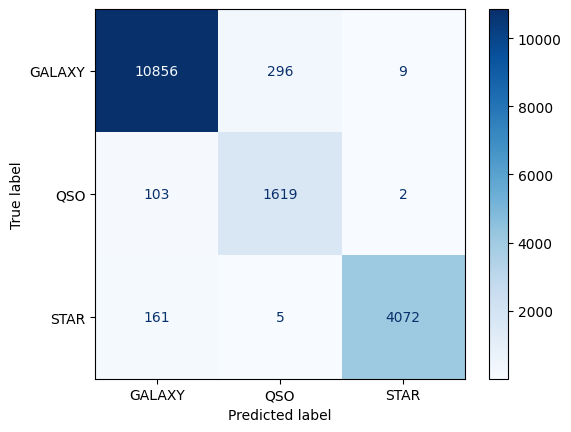

In [4]:
svc_holdout = SVC()
svc_holdout.fit(star_x_train, star_y_train)
evaluate_classification_model(svc_holdout, star_x_test, star_y_test)

The accuracy score calculated shows that the model is performing well, as it predicts the correct label for 96.6% of the samples in the test set. Additionally, since the precision and recall are balanced, this shows that the model doesn't predict to many false positives or false negatives. The confusion matrix shows that model struggles to classify quasars more than stars or galaxies, as approximately 6.1% of quasars were incorrectly predicted compared to 2.7% of galaxies and 3.9% of stars.

#### Train and evaluate an SVM classifier using cross-validation <a class="anchor" id="Train-and-evaluate-an-SVM-classifier-using-cross-validation"></a>

Next, we can create an SVM classifier and evaluate it using cross-validation to get a better estimate of the model's performance, and calculate the mean accuracy and standard deviation of the model's performance across the folds.

In [16]:
svc_cv = SVC()
svc_cv_scores = cross_val_score(svc_cv, star_X, star_Y, scoring='accuracy', n_jobs=-1)
print(f'Mean accuracy: {svc_cv_scores.mean()}')
print(f'Standard deviation: {svc_cv_scores.std()}')

Mean accuracy: 0.9644096152996191
Standard deviation: 0.0008522282547938581


The high mean accuracy and low standard deviation of the model's performance across the folds shows that the model is performing well. However, there is still room for improvement with an SVM classifier, thus the next step is to perform hyperparameter tuning to improve the model's performance.

#### Perform SVM classifier hyperparameter tuning <a class="anchor" id="Perform-SVM-classifier-hyperparameter-tuning"></a>

To tune the hyperparameters of a machine learning model, a common approach is to use the grid search method. This involves creating a grid of possible values for each hyperparameter, then training and evaluating a model for each combination of hyperparameters. The best performing model is then selected, and the hyperparameters used to create it are returned. In this task, SciKit-Learn's `GridSearchCV` class will be used to perform grid search as it is a simple and effective way to perform hyperparameter tuning while also performing cross-validation.

Due to large dataset sizes resulting in longer training times, hyperparameter tuning will be performed in stages for the star dataset, starting with the `kernel` parameter. This is opposed to performing a full grid search over all hyperparameters at once (which will be performed on the GWP dataset later).

In [9]:
def tune_parameters(model, param_grid, X, Y, scoring='accuracy'):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, n_jobs=-1, verbose=1)
    grid_search.fit(X, Y)

    print(f'Best Parameters:')
    for k, v in grid_search.best_params_.items():
        print(f'{k} = {v}')

    return grid_search.best_params_

In [8]:
svc_kernels = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

_ = tune_parameters(SVC(), svc_kernels, star_X, star_Y)

Best Parameters:
kernel = rbf


From the results, it is clear that a model with an `rbf` kernel is the best performing. Let's now tune the `C` and `gamma` parameters for this kernel.

In [10]:
svc_rbf_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.1, 0.01, 0.001, 0.0001],
}

best_svc_params = tune_parameters(SVC(kernel='rbf'), svc_rbf_grid, star_X, star_Y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters:
C = 1000
gamma = 0.1


#### Evaluate the tuned SVM classifier <a class="anchor" id="Evaluate-the-tuned-SVM-classifier"></a>

With these parameters, we can now train another SVM classifier and evaluate it using cross-validation, so that an effective comparison can be made with the previous model.

In [11]:
svc_tuned = SVC(**best_svc_params)
svc_tuned_scores = cross_val_score(svc_tuned, star_X, star_Y, scoring='accuracy', cv=10, n_jobs=-1)
print(f'Mean accuracy: {svc_tuned_scores.mean()}')
print(f'Standard deviation: {svc_tuned_scores.std()}')

Mean accuracy: 0.9725392085013876
Standard deviation: 0.001162952279931272


This model shows a solid improvement in accuracy over the previous model, given how high the accuracy of the previous model was. The mean accuracy of this model is 0.973 with a standard deviation of 0.001.

Accuracy: 0.9724931378847165
Precision: 0.9721448686511166
Recall: 0.9724931378847165
F1-score: 0.9721938371521196


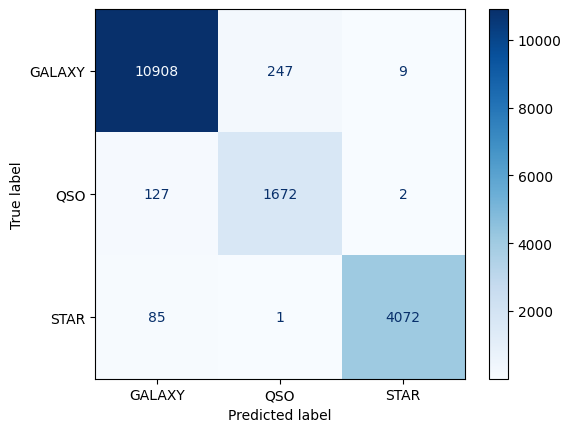

In [12]:
svc_tuned.fit(star_x_train, star_y_train)
evaluate_classification_model(svc_tuned, star_x_test, star_y_test)

When comparing this confusion matrix to the one produced by the initial SVM classifier, it is clear that the model has improved by the fact that the number of correctly predicted labels has increased. Interestingly, the number of samples incorrectly predicted as stars has remained the same, potentially indicating that some outliers still exist that the model struggles to classify. Additionally, the tuned model has incorrectly predicted more quasars as galaxies than the intial model.

## GWP Dataset <a class="anchor" id="GWP-Dataset"></a>

Similar to the star dataset, let's use a function created in task 3.1 to preprocess the GWP dataset.

In [2]:
gwp_X, gwp_Y = preprocess_gwp_dataset('datasets/gwp_assessment.csv')

#### Train and evaluate a Random Forest regressor using the holdout method <a class="anchor" id="Train-and-evaluate-a-Random-Forest-regressor-using-the-holdout-method"></a>

The model that will be used for the GWP dataset is a Random Forest Regressor, which is a type of supervised learning model that can be used for regression tasks (Random Forest Classifiers can be used for classification). According to the SciKit-Learn [documentation](https://scikit-learn.org/stable/modules/ensemble.html#random-forests), the principle behind a Random Forest is that it is an ensemble of decision trees, with each tree created using a random subset of the training data and its features. The predictions of each tree are averaged to generate the final prediction of the model for each sample. Again, let's first split the dataset into training and testing sets.

In [3]:
gwp_x_train, gwp_x_test, gwp_y_train, gwp_y_test = train_test_split(gwp_X, gwp_Y, test_size=0.2)

Then we can train a Random Forest Regressor using the training set and evaluate it using the test set. The metrics that will be used to evaluate the model are the R<sup>2</sup> score, mean absolute error, and mean squared error. Additionally, a plot of the predicted GWP values against the actual GWP values will be created to visualise the model's performance.

R^2 Score: 0.3069309940810545
Mean Absolute Error: 0.08422966800338588
Root Mean Squared Error: 0.13821754314400803


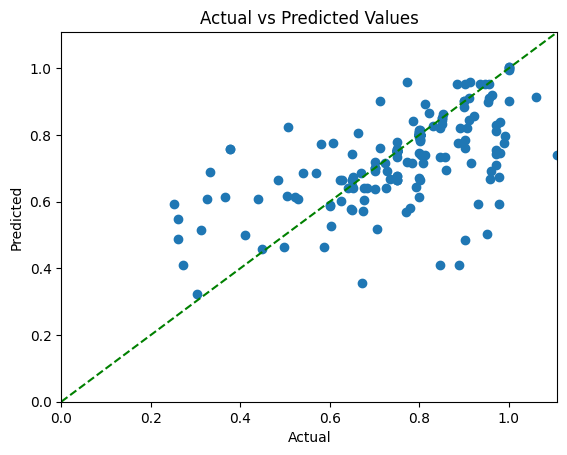

In [4]:
rf_holdout = RandomForestRegressor()
rf_holdout.fit(gwp_x_train, gwp_y_train)
evaluate_regression_model(rf_holdout, gwp_x_test, gwp_y_test)

The R<sup>2</sup> score of the Random Forest Classifier model is 0.31 which is fairly low, indicating that the model may struggle to accurately predict the actual productivity of samples in the testing set. However, due to the nature of the dataset attempting to predict the actual productivity of humans, a relatively low R^2 score is expected. The mean absolute error and root mean squared error are 0.08 and 0.14 respectively, which reflect this as they are fairly low values given the actual values range from 0.2 to 1.1 in the testing set. The plot of the predicted GWP values against the actual GWP values also shows that the model predicts some samples accurately (given how close many are to the line y=x), but others are predicted poorly.

#### Train and evaluate a Random Forest regressor using cross-validation <a class="anchor" id="Train-and-evaluate-a-Random-Forest-regressor-using-cross-validation"></a>

Next, we can train a Random Forest Regressor using cross-validation to get a better estimate of the model's performance, and calculate the mean R^2 score and standard deviation of the model's performance across the folds

In [7]:
rf_cv = RandomForestRegressor()
rf_cv_scores = cross_val_score(rf_cv, gwp_X, gwp_Y, scoring='r2', n_jobs=-1)
print(f'Mean R^2 score: {rf_cv_scores.mean()}')
print(f'Standard deviation: {rf_cv_scores.std()}')

Mean R^2 score: 0.23898625302464058
Standard deviation: 0.10716368715589561


The mean R<sup>2</sup> score of a standard Random Forest Regressor model on the GWP dataset was found to be 0.24, with a standard deviation of 0.11 across the folds. The high standard deviation in comparison to the mean R<sup>2</sup> score indicates that the performance of the model varies significantly across the folds. This could be because of the randomness involved with creating the trees in each Random Forest, as they are created using a random subset of the training data and features. Next, we will attempt to reduce this deviation in performance across the folds by tuning the hyperparameters of the model, as well as increase the mean R<sup>2</sup> score.

#### Perform Random Forest regressor hyperparameter tuning <a class="anchor" id="Perform-Random-Forest-regressor-hyperparameter-tuning"></a>

As this dataset is much smaller than the star dataset, we can perform a full grid search over all hyperparameters at once. For a Random Forest Regressor, the main hyperparameters tuned are:
- `n_estimators`: The number of trees in the forest
- `max_depth`: The maximum depth of the tree
- `min_samples_split`: The minimum number of samples required to split an internal node
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node
- `bootstrap`: Whether bootstrap samples are used when building trees

The hyperparameters used in the grid search are selected based upon knowledge gained from reading the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for the `RandomForestRegressor` class.

In [10]:
rf_param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

best_rf_params = tune_parameters(RandomForestRegressor(), rf_param_grid, gwp_X, gwp_Y, scoring='r2')

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Parameters:
bootstrap = True
max_depth = 40
min_samples_leaf = 4
min_samples_split = 2
n_estimators = 50


#### Evaluate the tuned Random Forest regressor <a class="anchor" id="Evaluate-the-tuned-Random-Forest-regressor"></a>

Now that the best hyperparameters have been found, we can create another Random Forest Regressor model using these parameters and evaluate it using cross-validation.

In [18]:
rf_tuned = RandomForestRegressor(**best_rf_params)
rf_tuned_scores = cross_val_score(rf_tuned, gwp_X, gwp_Y, scoring='r2', n_jobs=-1)
print(f'Mean R^2 score: {rf_tuned_scores.mean()}')
print(f'Standard deviation: {rf_tuned_scores.std()}')

Mean R^2 score: 0.255160770929521
Standard deviation: 0.047302966517413614


With the tuned model, a mean R<sup>2</sup> score of 0.26 was achieved which is an improvement over the previous score of 0.24. Additionally, the standard deviation of the model's performance across the folds was drastically reduced from 0.11 to 0.05, showing that performance is more consistent.

R^2 Score: 0.41926771785528294
Mean Absolute Error: 0.07994602911214337
Root Mean Squared Error: 0.12652108699727682


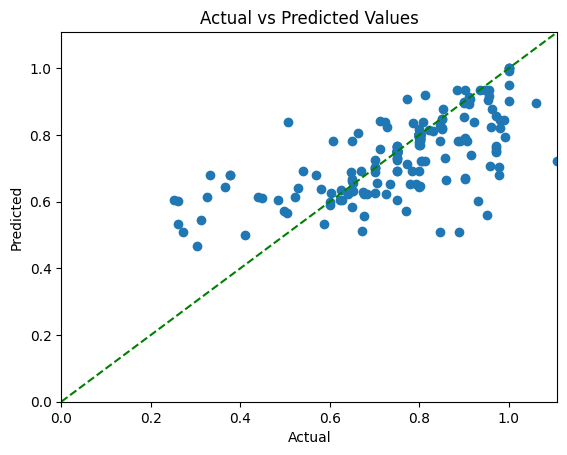

In [11]:
rf_tuned.fit(gwp_x_train, gwp_y_train)
evaluate_regression_model(rf_tuned, gwp_x_test, gwp_y_test)

Evidently, in comparison to the previous model, the tuned Random Forest model clearly achieves a better performance which is reflected in the smaller mean absolute error and root mean squared error values. The plot of predicted vs actual values also shows that the model is better at predicting the productivity since the points are more tightly grouped around the line y=x.

## Markdown Question <a class="anchor" id="Markdown-Question"></a>

*Is Linear Regression a good model to use for the star dataset? Justify your answer.*

Linear regression models assume a linear relationship between the features and the target variable, which isn't true in the case of many classification problems. In the star dataset, the target variable is categorical, namely having the classes `galaxy`, `qso` and `star`, meaning it is suited to be a classification task. Therefore, linear regression isn't a suitable model to use for this dataset, as there may not be a linear relationship between the features and the target. Additionally, using a linear regression model for the star dataset may result in predictions being made that don't fall into any of the three categories, making the predictions harder to interpret (and in certain cases, meaningless). Another reason why they shouldn't be used is that evaluation metrics commonly used for regression models, such as RMSE, are not suitable to be used for classification tasks, which use other metrics, including accuracy and F1-score. Finally, linear regression models are more sensitive to outliers than those suited to classification, which may result in the model being less accurate than a classification model.